In [104]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import eigsh
import scipy as sps
import csv

#define constant

omega  = 110.7          #mev
d      = 1.420          #angstrom, whatever is ok.
hv     = 1.5*d*2970     #meV*angstrom, Fermi velocity for SLG
N      = 15              #truncate range
valley = 1             #+1 for K, -1 for K'
KDens  = 100            #density of k points, 100 is good.

#tune parameters

I      = complex(0, 1)
ei120  = np.cos(2*np.pi/3) + valley*I*np.sin(2*np.pi/3)
ei240  = np.cos(2*np.pi/3) - valley*I*np.sin(2*np.pi/3)



Tqb    = omega*np.array([[1,1], [1,1]], dtype=complex)
Tqtr   = omega*np.array([[ei120, 1], [ei240, ei120]], dtype=complex)
Tqtl   = omega*np.array([[ei240, 1], [ei120, ei240]], dtype=complex)
TqbD   = np.array(np.matrix(Tqb).H)
TqtrD  = np.array(np.matrix(Tqtr).H)
TqtlD  = np.array(np.matrix(Tqtl).H)

#define Lattice
L = []
invL = np.zeros((2*N+1, 2*N+1), int)

def Lattice(n):
    count = 0
    for i in np.arange(-n, n+1):
        for j in np.arange(-n, n+1):
            L.append([i, j])
            invL[i+n, j+n] = count
            count = count + 1
    for i in np.arange(-n, n+1):
        for j in np.arange(-n, n+1):
            L.append([i, j])

Lattice(N)
siteN = (2*N+1)*(2*N+1)
L = np.array(L)

levels = 60


def Hamiltonian(kx, ky, theta):
    
    theta  = theta/180.0*np.pi 
    b1m    = 8*np.pi*np.sin(theta/2)/3/d*np.array([0.5, -np.sqrt(3)/2])
    b2m    = 8*np.pi*np.sin(theta/2)/3/d*np.array([0.5, np.sqrt(3)/2])
    qb     = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d*np.array([0, -1])
    K1     = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d*np.array([-np.sqrt(3)/2,-0.5])
    K2     = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d*np.array([-np.sqrt(3)/2,0.5])
    H = np.array(np.zeros((4*siteN, 4*siteN)), dtype=complex)
    
    for i in np.arange(siteN):
        #diagonal term
        ix = L[i, 0]
        iy = L[i, 1]
        ax = kx - valley*K1[0] + ix*b1m[0] + iy*b2m[0]
        ay = ky - valley*K1[1] + ix*b1m[1] + iy*b2m[1]

        qx = np.cos(theta/2) * ax + np.sin(theta/2) * ay
        qy =-np.sin(theta/2) * ax + np.cos(theta/2) * ay
         
        H[2*i, 2*i+1] = hv * (valley*qx - I*qy)
        H[2*i+1, 2*i] = hv * (valley*qx + I*qy)

        #off-diagonal term
        j = i + siteN
        H[2*j, 2*i]     = TqbD[0, 0]
        H[2*j, 2*i+1]   = TqbD[0, 1]
        H[2*j+1, 2*i]   = TqbD[1, 0]
        H[2*j+1, 2*i+1] = TqbD[1, 1]
        if (iy != valley*N):
            j = invL[ix+N, iy+valley*1+N] + siteN
            H[2*j, 2*i]     = TqtrD[0, 0]
            H[2*j, 2*i+1]   = TqtrD[0, 1]
            H[2*j+1, 2*i]   = TqtrD[1, 0]
            H[2*j+1, 2*i+1] = TqtrD[1, 1]
        if (ix != -valley*N):
            j = invL[ix-valley*1+N, iy+N] + siteN
            H[2*j, 2*i]     = TqtlD[0, 0]
            H[2*j, 2*i+1]   = TqtlD[0, 1]
            H[2*j+1, 2*i]   = TqtlD[1, 0]
            H[2*j+1, 2*i+1] = TqtlD[1, 1]
        

    for i in np.arange(siteN, 2*siteN):
        #diagnoal term
        j = i - siteN
        ix = L[j, 0]
        iy = L[j, 1]
        ax = kx  - valley*K2[0] + ix*b1m[0] + iy*b2m[0] 
        ay = ky  - valley*K2[1] + ix*b1m[1] + iy*b2m[1]

        qx = np.cos(theta/2) * ax - np.sin(theta/2) * ay
        qy = np.sin(theta/2) * ax + np.cos(theta/2) * ay

        H[2*i, 2*i+1] = hv * (valley*qx - I*qy)
        H[2*i+1, 2*i] = hv * (valley*qx + I*qy)

        #off-diagonal term
        H[2*j, 2*i]     = Tqb[0, 0]
        H[2*j, 2*i+1]   = Tqb[0, 1]
        H[2*j+1, 2*i]   = Tqb[1, 0]
        H[2*j+1, 2*i+1] = Tqb[1, 1]
        if (iy != (-valley*N)):
            j = invL[ix+N, iy-valley*1+N]
            H[2*j, 2*i]     = Tqtr[0, 0]
            H[2*j, 2*i+1]   = Tqtr[0, 1]
            H[2*j+1, 2*i]   = Tqtr[1, 0]
            H[2*j+1, 2*i+1] = Tqtr[1, 1]
        if (ix != valley*N):
            j = invL[ix+valley*1+N, iy+N]
            H[2*j, 2*i]     = Tqtl[0, 0]
            H[2*j, 2*i+1]   = Tqtl[0, 1]
            H[2*j+1, 2*i]   = Tqtl[1, 0]
            H[2*j+1, 2*i+1] = Tqtl[1, 1]


    eigensystem = sps.sparse.linalg.eigsh(H, k = levels, which = "SM")
    
    return eigensystem
            
sigma = np.array(np.zeros((4*siteN, 4*siteN)), dtype=complex)

for i in np.arange(2*siteN):
        sigma[2*i, 2*i+1] = 1
        sigma[2*i+1, 2*i] = 1
        
f = np.array(np.zeros((levels), dtype=int))

for i in np.arange(int(levels/2)):
    f[i] = 1
    
eta = 3 # broadening of resonances in meV

def DinamCond(theta, en):
    
    # returns sigma_xx/sigma_mono following Moon Koshino (2013)
    # the output has dimensions 1/angstrom^2. all energies are treated in meV.
    
    eig_vec = Hamiltonian(0,0,theta)
#    eig_vec = Hamiltonian(0.5*np.sqrt(3)*kD,0,theta)
    sorted_eig_ens = np.sort(eig_vec[0])
    sorted_eig_vec = []
    argsort = eig_vec[0].argsort(axis=None)
    for i in np.arange(levels):
        sorted_eig_vec.append(eig_vec[1][:,np.where(argsort==i)])
    sorted_eig_vec = np.array(sorted_eig_vec)
    sorted_eig_vec = np.squeeze(sorted_eig_vec)
    
#    S = d**2*0.5*np.sqrt(3)*0.25*(1/np.sin(0.5*theta*np.pi/180))**2
    
#    sigma_xx = 0
    Resigma_xx = 0
    Imsigma_xx = 0
    
    for i in np.arange(levels):
        for j in np.arange(levels):
                if i!=j:
                    matrix_element = np.abs(np.dot(sorted_eig_vec[i], np.matmul(sigma, sorted_eig_vec[j])))
                    Ei = sorted_eig_ens[i]
                    Ej = sorted_eig_ens[j]
#                    sigma_xx += (f[i]-f[j])*(4/en)*hv**2*matrix_element**2/(Ei-Ej+en+1.j*eta)
                    Resigma_xx += (f[i]-f[j])*(4/en)*hv**2*matrix_element**2*(eta/((Ei-Ej+en)**2+eta**2))
                    Imsigma_xx += (f[i]-f[j])*(4/en)*hv**2*matrix_element**2*((Ei-Ej+en)/((Ei-Ej+en)**2+eta**2))
#                    Resigma_xx += (f[i]-f[j])*(4/en)*(hv**2/S)*matrix_element**2*(eta/((Ei-Ej+en)**2+eta**2))
#                    Imsigma_xx += (f[i]-f[j])*(4/en)*(hv**2/S)*matrix_element**2*((Ei-Ej+en)/((Ei-Ej+en)**2+eta**2))
#    return sigma_xx/1.j
    return Resigma_xx, Imsigma_xx

In [121]:
eig_vec = Hamiltonian(0,0,5)

In [123]:
eig_vec[0].shape

(60,)

In [108]:
eig_vec = Hamiltonian(0,0,5)
#eig_vec = Hamiltonian(0.5*np.sqrt(3)*kD,0,theta)
sorted_eig_ens = np.sort(eig_vec[0])
sorted_eig_vec = []
argsort = eig_vec[0].argsort(axis=None)
for i in np.arange(levels):
    sorted_eig_vec.append(eig_vec[1][:,np.where(argsort==i)])
sorted_eig_vec = np.array(sorted_eig_vec)
sorted_eig_vec = np.squeeze(sorted_eig_vec)

In [109]:
sorted_eig_ens

array([-3302.24869673, -3302.2486823 , -3302.2486823 , -3297.92949807,
       -3297.92949807, -3297.92948297, -2700.11858518, -2700.11463096,
       -2700.11463096, -2526.63671937, -2526.63671937, -2526.26319461,
       -2524.0897678 , -2523.72264137, -2523.72264137, -2267.32752126,
       -2267.32752126, -2267.32556405, -1843.70237889, -1843.69913784,
       -1843.69913784, -1838.25520436, -1838.25520436, -1838.18934857,
       -1151.50532348, -1127.75256502, -1127.75256502,  -737.46745766,
        -737.46745766,  -723.55042937,   713.07858558,   734.04311903,
         734.04311903,  1129.58136775,  1129.58136775,  1160.35790543,
        1837.46811593,  1837.60641561,  1837.60641561,  1843.14817498,
        1843.14817498,  1843.24950114,  2265.43154413,  2265.43762815,
        2265.43762815,  2522.67714397,  2522.67714397,  2523.01020677,
        2528.73288848,  2529.07377924,  2529.07377924,  2701.82696625,
        2701.82696625,  2701.83455769,  3297.09766474,  3297.09769161,
      

In [110]:
sorted_eig_vec

array([[ 5.81630468e-19+1.63192873e-18j,  3.47048659e-18-5.57310776e-19j,
         5.46302220e-18+1.15842282e-18j, ...,
         1.68072971e-20-2.23814502e-19j, -1.93643713e-18+4.49700682e-18j,
         2.12097125e-19-2.65759591e-18j],
       [-4.51232050e-18-2.14533945e-18j, -8.43215679e-18+7.68788330e-18j,
        -1.13685275e-17-5.23051459e-18j, ...,
         4.34133754e-19+3.04530645e-18j,  1.81149734e-17-3.97579088e-17j,
        -1.96890137e-17+4.69774807e-17j],
       [-3.64203491e-18-9.99430741e-18j, -1.04407991e-17+2.77803780e-18j,
        -2.00211470e-18-7.87542537e-22j, ...,
         4.06767382e-19+1.29624041e-18j, -3.71996694e-18+1.06260458e-17j,
         3.97316079e-18-1.28558805e-17j],
       ...,
       [-4.23797875e-18+1.62356202e-17j,  1.08658362e-18-2.06091568e-17j,
        -2.98599489e-18+4.69289738e-18j, ...,
        -3.70758744e-18-9.83222154e-18j,  8.07731144e-18+3.13302093e-18j,
         5.54109368e-18+1.49102283e-17j],
       [ 3.41921988e-18+7.47762596e-18j,  7.

In [111]:
sorted_eig_vec[0]

array([ 5.81630468e-19+1.63192873e-18j,  3.47048659e-18-5.57310776e-19j,
        5.46302220e-18+1.15842282e-18j, ...,
        1.68072971e-20-2.23814502e-19j, -1.93643713e-18+4.49700682e-18j,
        2.12097125e-19-2.65759591e-18j])

In [112]:
np.dot(np.conj(sorted_eig_vec[0]),np.matmul(sigma, sorted_eig_vec[0]))

(-0.2479862986233987+0j)

In [113]:
np.dot(np.conj(sorted_eig_vec[1]),np.matmul(sigma, sorted_eig_vec[1]))

(-4.54523363391246e-11+0j)

In [115]:
np.dot(np.conj(sorted_eig_vec[:]),np.matmul(sigma, sorted_eig_vec[:]))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 60 is different from 3844)

In [118]:
velocities = np.array(np.dot(np.conj(sorted_eig_vec[i]),np.matmul(sigma, sorted_eig_vec[i])) for i in range(10))
velocities[0]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [120]:
velocities = np.zeros(levels)
for i in np.arange(levels):
    velocities[i] = np.dot(np.conj(sorted_eig_vec[i]),np.matmul(sigma, sorted_eig_vec[i]))

print(velocities)

<ipython-input-120-b15fd15f8d50>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  velocities[i] = np.dot(np.conj(sorted_eig_vec[i]),np.matmul(sigma, sorted_eig_vec[i]))


[-2.47986299e-01 -4.54523363e-11  2.38238524e-01  2.30027050e-01
  3.59555655e-01  2.54690369e-01 -3.59553843e-01 -3.01577503e-09
 -7.25692943e-12 -2.34294234e-01 -1.04965671e-08  3.69458477e-01
  4.74504520e-01 -3.61930870e-01 -5.20699803e-12 -2.65587242e-09
 -3.54468711e-01 -2.79476789e-02  8.97260033e-02 -8.83085940e-02
  9.93393305e-10  2.99588219e-02 -2.97823571e-10 -4.73153092e-01
 -1.97092342e-11  1.06810453e-01  2.28727828e-10  9.69288538e-12
 -1.06836255e-01  2.10478744e-01 -1.72047325e-01  3.54693648e-01
  3.59501181e-02  1.07341636e-11  1.68669794e-01 -3.08247867e-02
 -2.34900126e-01  2.60104217e-01 -2.53812950e-01 -4.66584430e-02
 -3.14403621e-01 -3.18293143e-01 -2.21079030e-08  3.17535791e-01
 -2.11273549e-01  3.14902223e-01  4.22624012e-02 -5.74758721e-06
  1.62689306e-13  6.76168790e-02 -6.87592344e-14 -2.38142839e-13
 -6.74625298e-02 -8.75369222e-13  4.39994911e-01 -9.96757914e-02
  1.59007324e-06 -4.40179361e-01 -1.46130335e-07  9.94543601e-02]


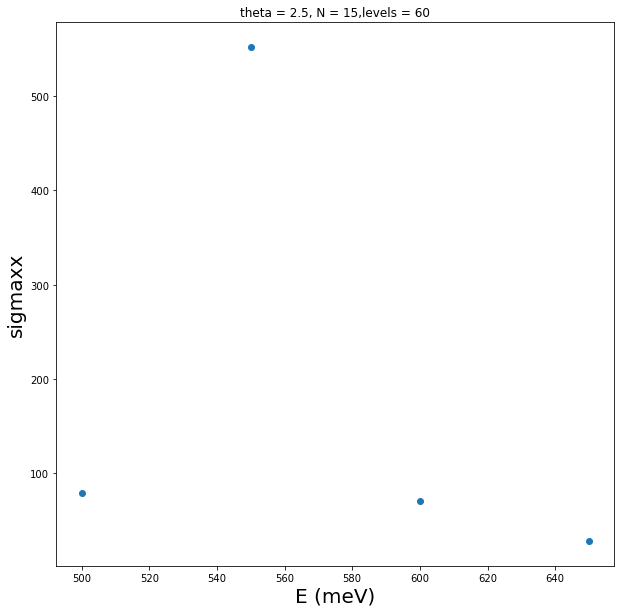

In [107]:
dinam_conds = []
imag_conds = []

Num = 4
angle = 2.5

for i in range(Num):
    en = 500 + 50*i
    dinam_conds.append([en, DinamCond(angle, en)[0]])
#    dinam_conds.append([angle, en, np.real(DinamCond(angle, en)), np.imag(DinamCond(angle, en))])
#    imag_conds.append([en, np.imag(DinamCond(angle, en))])

dinam_conds
x, y = np.array(dinam_conds).T

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.ylabel('sigmaxx', fontsize=20)
plt.xlabel('E (meV)', fontsize=20)
plt.title( "theta = " + str(angle) + ", N = " + str(N) + ",levels = " + str(levels) )
plt.show()

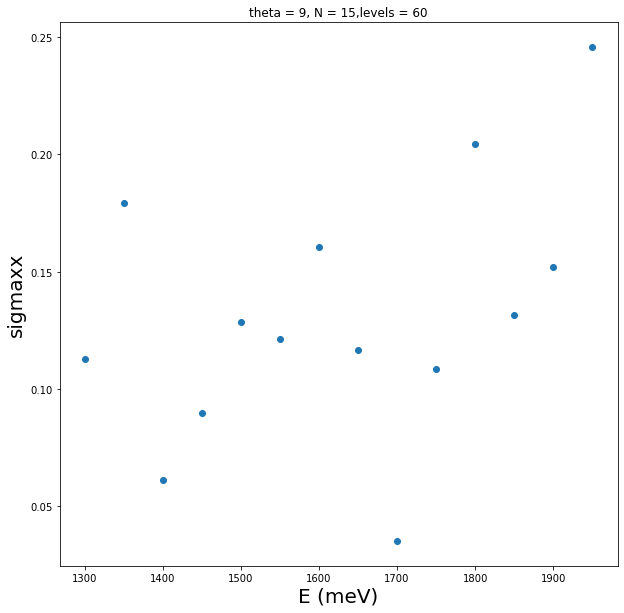

In [30]:
dinam_conds = []
imag_conds = []

Num = 14
angle = 2

for i in range(Num):
    en = 1300 + 50*i
    dinam_conds.append([angle, en, np.real(DinamCond(angle, en)), np.imag(DinamCond(angle, en))])
#    imag_conds.append([en, np.imag(DinamCond(angle, en))])

dinam_conds
x, y = np.array(dinam_conds).T

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.ylabel('sigmaxx', fontsize=20)
plt.xlabel('E (meV)', fontsize=20)
plt.title( "theta = " + str(angle) + ", N = " + str(N) + ",levels = " + str(levels) )
plt.show()

In [86]:
with open('sigma_xx.csv', 'w', encoding='UTF8', newline='') as file:
    writer = csv.writer(file)
    header = ['Angle', 'Energy', 'Re_sigma_xx', 'Im_sigma_xx']
    writer.writerow(header)
    for angle in range(10,20):
        Num = 14*5
        for i in range(Num):
            en = 1300 + 10*i
            writer.writerow([angle, en, np.real(DinamCond(angle, en)), np.imag(DinamCond(angle, en))])

In [106]:
dinam_conds

[[1300, 630.5965139935753],
 [1350, 38.925163529414384],
 [1400, 40.16679453151366],
 [1450, 88.97042786544777],
 [1500, 493.44061424909927],
 [1550, 1305.8774977020066],
 [1600, 134.14377818711597],
 [1650, 1060.4233367043148],
 [1700, 11007.142798812023],
 [1750, 245.42304377330782],
 [1800, 931.7382410828275],
 [1850, 1205.2977144614601],
 [1900, 958.358524124495],
 [1950, 162.6382837032406]]

In [ ]:
conds5 = [[1300, 5.252293660975694],
 [1350, 4.567598569476645],
 [1400, 0.4252526265390444],
 [1450, 66.88617808939239],
 [1500, 15.164060582092022],
 [1550, 9.544643217487637],
 [1600, 28.112304188254807],
 [1650, 11.258421104179085],
 [1700, 0.7184946340665195],
 [1750, 3.7433492099038554],
 [1800, 247.06503037593512],
 [1850, 52.18708641445488],
 [1900, 88.35346941812196],
 [1950, 24.232192223650273]]

conds6 = [[1300, 0.9384140448998127],
 [1350, 0.8040657660542087],
 [1400, 0.6021185488020895],
 [1450, 1.3267543588647717],
 [1500, 1.1291545518951116],
 [1550, 0.5823801656695216],
 [1600, 2.008763606582156],
 [1650, 5.389850579716519],
 [1700, 0.3382483691621822],
 [1750, 1.0370490768969693],
 [1800, 22.32195881659115],
 [1850, 3388.6791583248346],
 [1900, 54.95756112434922],
 [1950, 18.15984309056459]]

conds7 = [[1300, 0.3821868143780454],
 [1350, 0.15546631545310902],
 [1400, 0.2586911987866697],
 [1450, 0.3265806733935792],
 [1500, 0.4972373188660809],
 [1550, 0.5153226137705862],
 [1600, 0.5760045541992608],
 [1650, 0.5913816699135684],
 [1700, 0.573244531601561],
 [1750, 0.665600538927251],
 [1800, 0.6444337213070291],
 [1850, 0.3289396821581938],
 [1900, 0.157306370087672],
 [1950, 1.8410358902945279]]

iconds7 = [[1300, -40.45874532929643],
 [1350, -48.537821530384576],
 [1400, -70.1946055779434],
 [1450, -65.19993695865664],
 [1500, -35.96621904023795],
 [1550, -50.30220224476713],
 [1600, -95.33943743865744],
 [1650, -102.29231436479017],
 [1700, -31.971923313118054],
 [1750, -56.894588326593016],
 [1800, -136.85652241289847],
 [1850, -220.4840390280082],
 [1900, -76.26264698285932],
 [1950, -140.57247367607246]]

conds8 = [[1300, 0.1656248299773867],
 [1350, 0.22267677832574234],
 [1400, 0.2609075331964035],
 [1450, 0.10989313632097907],
 [1500, 0.13989813027703252],
 [1550, 0.2326159092624772],
 [1600, 0.2694335318202795],
 [1650, 0.4196392721833071],
 [1700, 0.37612641899279586],
 [1750, 0.4046575846012994],
 [1800, 0.4180688426882078],
 [1850, 0.5333383897629719],
 [1900, 0.3273348017468678],
 [1950, 0.3789225046449524]]

iconds8 = [[1300, -28.030108792748063],
 [1350, -25.73116143141427],
 [1400, -44.974962429632086],
 [1450, -39.30927875654269],
 [1500, -38.454854646765824],
 [1550, -31.452334760352336],
 [1600, -53.82262143250215],
 [1650, -59.446460666748074],
 [1700, -24.440438555910056],
 [1750, -75.9549817901958],
 [1800, -48.21727388435952],
 [1850, -73.18396348333972],
 [1900, -69.48944118749955],
 [1950, -61.72383226310177]]

conds9 = [[1300, 0.11301470742429941],
 [1350, 0.17937859855283808],
 [1400, 0.0614173354833207],
 [1450, 0.08963571604668549],
 [1500, 0.1285276146597269],
 [1550, 0.12112979289089013],
 [1600, 0.16046031938051572],
 [1650, 0.11670116102467458],
 [1700, 0.03518393550518082],
 [1750, 0.10843599137442173],
 [1800, 0.20446552141186733],
 [1850, 0.1317567902678599],
 [1900, 0.1521735221864947],
 [1950, 0.2458420214393776]]

iconds9 = [[1300, -16.473418658208278],
 [1350, -14.914364221944048],
 [1400, -31.875643449760158],
 [1450, -29.920597170180432],
 [1500, -29.231716539482225],
 [1550, -44.9606368737315],
 [1600, -46.79056718141437],
 [1650, -36.828395965227365],
 [1700, -34.11004932168901],
 [1750, -26.626888968258505],
 [1800, -32.6709783126259],
 [1850, -44.77490626193301],
 [1900, -65.86337683226223],
 [1950, -46.15128881044951]]

In [32]:
imag_conds

[[1300, -16.473418658208278],
 [1350, -14.914364221944048],
 [1400, -31.875643449760158],
 [1450, -29.920597170180432],
 [1500, -29.231716539482225],
 [1550, -44.9606368737315],
 [1600, -46.79056718141437],
 [1650, -36.828395965227365],
 [1700, -34.11004932168901],
 [1750, -26.626888968258505],
 [1800, -32.6709783126259],
 [1850, -44.77490626193301],
 [1900, -65.86337683226223],
 [1950, -46.15128881044951]]

In [103]:
data = pd.read_csv('sigma_xx.csv')
data.head()

,Angle,Energy,Re_sigma_xx,Im_sigma_xx
0,10,1300,0.090984,-20.572359
1,10,1310,0.058550,-10.861771
2,10,1320,0.067548,-13.933767
3,10,1330,0.084645,-16.723355
4,10,1340,0.062812,-23.234074


In [57]:
import csv
 
# Create header and data variables
header = ['Energy', 'Re_sigma_xx', 'Im_sigma_xx']
data = [1000, 5, 6]
 
with open('sigma_xx.csv', 'w', encoding='UTF8', newline='') as file:
    # Create a writer object
    writer = csv.writer(file)
    # Write the header
    writer.writerow(header)
    # Write the data
    writer.writerow(data)

In [66]:
with open('sigma_xx.csv', 'w', encoding='UTF8', newline='') as file:
    # Create a writer object
    writer = csv.writer(file)
    # Write the header
    writer.writerow(header)
    # Write the data
    writer.writerow([5, 6, 7])
    writer.writerow([7, 3, 2])
    writer.writerow([8, 2, 5])
    writer.writerow([9, 3, 10])

In [67]:
import pandas as pd

data = pd.read_csv('sigma_xx.csv')

In [68]:
data.head()

,Energy,Re_sigma_xx,Im_sigma_xx
0,5,6,7
1,7,3,2
2,8,2,5
3,9,3,10


In [69]:
data['Energy']

0    5
1    7
2    8
3    9
Name: Energy, dtype: int64

In [70]:
data['Re_sigma_xx']

0    6
1    3
2    2
3    3
Name: Re_sigma_xx, dtype: int64

<AxesSubplot:xlabel='Energy'>

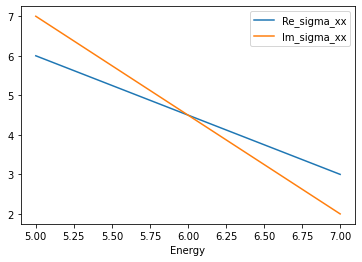

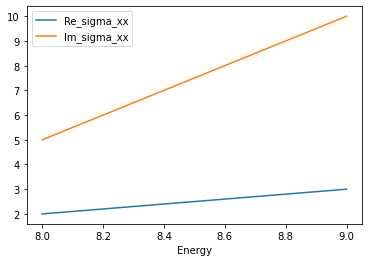

In [74]:
data[0:2].plot(x="Energy", y=["Re_sigma_xx", "Im_sigma_xx"])
data[2:].plot(x="Energy", y=["Re_sigma_xx", "Im_sigma_xx"])

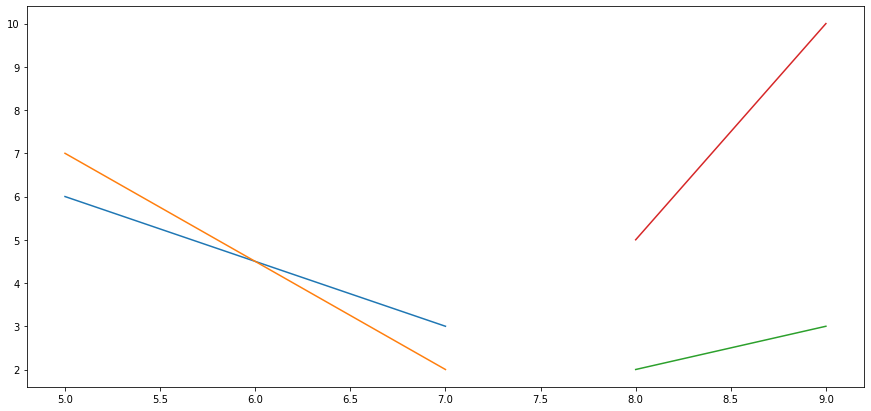

In [80]:
plt.figure(figsize=(15, 7))
plt.plot(data[0:2].Energy, data[0:2].Re_sigma_xx, label = 're, angle1')
plt.plot(data[0:2].Energy, data[0:2].Im_sigma_xx, label = 'im, angle1')
plt.plot(data[2:].Energy, data[2:].Re_sigma_xx, label = 're, angle2')
plt.plot(data[2:].Energy, data[2:].Im_sigma_xx, label = 'im, angle2')
plt.show()

In [76]:
data.Energy

0    5
1    7
2    8
3    9
Name: Energy, dtype: int64

In [77]:
data.Re_sigma_xx

0    6
1    3
2    2
3    3
Name: Re_sigma_xx, dtype: int64

In [124]:
from scipy.linalg import block_diag

block_diag(np.zeros((2,2)),5)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 5.]])

In [129]:
sigma = np.zeros((2,2))
sigma[0][0]=sigma[1][1]=0
sigma[1][0]=sigma[0][1]=1
np.kron(np.identity(3),sigma)

array([[0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.]])